In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from d2l import torch as d2l
import math
import random
import time
from torch.optim.optimizer import Optimizer
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.autograd import Function
from torch.autograd import Variable as V
import pandas as pd
device = d2l.try_gpu()

In [110]:
#vfosgd_pf
class VFOSGD_PF(Optimizer):


    def __init__(self, params, lr=1e-1,r=0.9):  #r on behalf of fractional order 
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
            
        if not -2.0 <= r:
            raise ValueError("Invalid r value: {}".format(r))
            
        defaults = dict(lr=lr,r=r)
        super(VFOSGD_PF, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(VFOSGD_PF, self).__setstate__(state)
        
    
    def step(self, closure=None):
        eps=1e-8
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('VFOSGD_PF does not support sparse gradients')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                 
                fractional_order_grad_other = grad.clone()
                
                state['step'] += 1
                
                r = group['r']
                
                step_size = group['lr']
                
                x = p.data
                #vfogd_pf
                y1 = torch.where(x <= 0, torch.tensor([eps]).to(device), x.to(device))
                y2 = torch.where(x > 0, torch.tensor([eps]).to(device), torch.tensor([1.0]).to(device))
                
                y1 = fractional_order_grad_other*y1**(1-r)/math.gamma(2-r)
                y2 = fractional_order_grad_other*y2
                
                g = y1 + y2
                
                p.data.add_(-step_size, g)

        return loss
    

    
#vfoAdam_pf
class VFOAdam_PF(Optimizer):


    def __init__(self, params, lr=1e-1, betas=(0.9, 0.999), eps=1e-8,r=0.9):  #r on behalf of fractional order 
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
         
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
            
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
            
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        if not -2.0 <= r:
            raise ValueError("Invalid r value: {}".format(r))
            
        defaults = dict(lr=lr, betas=betas, eps=eps,r=r)
        super(VFOAdam_PF, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(VFOAdam_PF, self).__setstate__(state)
        
    
    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('VFOAdam_PF does not support sparse gradients')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    #initialize first moment and second moment
                    state['m'] = 0;state['v'] = 0
                
                fractional_order_grad_other = grad.clone()
                    
                state['step'] += 1
                
                r = group['r']
                
                step_size = group['lr']
                
                beta1, beta2 = group['betas']
                
                x = p.data
                #vfogd_pf
                y1 = torch.where(x <= 0, torch.tensor([group['eps']]).to(device), x.to(device))
                y2 = torch.where(x > 0, torch.tensor([group['eps']]).to(device), torch.tensor([1.0]).to(device))
                
                y1 = fractional_order_grad_other*y1**(1-r)/math.gamma(2-r)
                y2 = fractional_order_grad_other*y2
                
                g = y1 + y2                
                
                state['m'] = torch.add(beta1*state['m'],(1-beta1)*g)
                
                state['v'] = torch.add(beta2*state['v'],(1-beta2)*g**2)
                
                m = state['m']/(1 - beta1**state['step'])
                
                v = state['v']/(1 - beta2**state['step'])
                
                p.data.add_(-step_size, m/(torch.sqrt(v) + group['eps']))
                
        return loss

In [3]:
#Mean Square Error
def MSE(pred,true):
    return np.mean((pred-true)**2)

#Root Mean Square Error
def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

#Mean Absolute Error
def MAE(pred, true):
    return np.mean(np.abs(pred-true))

#Mean Absolute Percentage Error
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

#Relative Squared Error
def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

'''
def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))
'''

#Coefficient of Determination
def R2(pred, true):
    return r2_score(pred,true) 

In [4]:
#DJIA data preprocessing
slide_windows_size = 30
pre_days = 1
df_DJIA = pd.read_csv(r'./data/DJIA.csv')
del df_DJIA['Date']
df_DJIA['label'] = df_DJIA['Close'].shift(-pre_days)
df_DJIA.dropna()
scaler = StandardScaler()
sca_X_DJIA = scaler.fit_transform(df_DJIA.iloc[:,:-1])
deq_DJIA = deque(maxlen=slide_windows_size)
X_DJIA = []
for i in sca_X_DJIA:
    deq_DJIA.append(list(i))
    if len(deq_DJIA)==slide_windows_size:
        X_DJIA.append(list(deq_DJIA))
X_DJIA = X_DJIA[:-pre_days]
y_DJIA = scaler.fit_transform(pd.DataFrame(df_DJIA['label'].values[slide_windows_size-1:-pre_days]))
X_DJIA, y_DJIA = torch.Tensor(X_DJIA),torch.Tensor(y_DJIA)
X_DJIA, y_DJIA = X_DJIA.to(device), y_DJIA.to(device)
X_train,X_test,y_train,y_test = train_test_split(X_DJIA,y_DJIA,test_size=0.2,shuffle=False)

In [5]:
#DJIA network model
class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.rnn = nn.LSTM(
            input_size=5,
            hidden_size=64,
            num_layers=3,
            dropout=0.2,
            batch_first=True
        )
        #self.linear_3 = nn.Linear(150,64)
        self.linear_1 = nn.Linear(64,32)
        self.linear_2 = nn.Linear(32,1)
    
    def forward(self,x):
        out,(hn,cn) = self.rnn(x)
        #x = x.view(-1,150)
        #hn = self.linear_3(x)
        hn1 = self.linear_1(hn[2])  #hn[2]
        hn2 = self.linear_2(hn1)
        hn3 = hn2.view(-1,1)
        #out = 0
        return out,hn3

In [8]:
#DJIA network model based on MLP
class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.linear_0 = nn.Linear(150,128)
        self.linear_1 = nn.Linear(128,64)
        self.linear_2 = nn.Linear(64,32)
        self.linear_3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = x.view(-1,150)
        hn0 = self.linear_0(x)
        hn1 = self.linear_1(hn0)
        hn2 = self.linear_2(hn1)
        hn3 = self.linear_3(hn2)
        hn3 = hn3.view(-1,1)
        out = 0
        return out,hn3

In [174]:
#DJIA train and test
epoch = 300
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

######
r = 0.6
#DJIA_VFOGD_PF_06_Loss = []
DJIA_VFOAdam_PF_06_Loss = []
######

Best_Accuracy_MSE = 10
Best_Accuracy_MAE = 10
Best_Accuracy_MAPE = 10
Best_Accuracy_RSE = 10
Best_Accuracy_R2 = -10

#choose optimizers
#optimizer1 = torch.optim.SGD(model.rnn.parameters(),lr=0.01,momentum=0.1)
#optimizer2 = VFOSGD_PF([{'params': model.linear_1.parameters()},
#                       {'params': model.linear_2.parameters()}],r=r,lr=0.01)
#optimizer2 = VFOAdam_PF([{'params': model.linear_1.parameters()},
#                       {'params': model.linear_2.parameters()}],r=r,lr=0.01)
#optimizer = VFOSGD_PF(model.parameters(),r=r,lr=0.01)

optimizer = VFOAdam_PF(model.parameters(),r=r,lr=0.00001)
for i in range(epoch):
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        model.zero_grad()
        out,hn4 = model(X_batch)
        loss = criterion(hn4,y_batch)       
        loss.backward()
        #optimizer1.step()
        #optimizer2.step()
        optimizer.step()
        loss_sum += loss
    print('epoch:{0}'.format(i+1)+'\n'+'loss:{0}'.format(loss_sum.cpu().detach().numpy()))
    
    ######
    DJIA_VFOAdam_PF_06_Loss.append(loss_sum.cpu().detach().numpy())
    ######
    
    model.eval()
    X_test, y_test = X_test.to(device), y_test.to(device)
    out_1,hn_1 = model(X_test)
    
    MSE_a = MSE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    MAE_a = MAE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    MAPE_a = MAPE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    RSE_a = RSE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    R2_a = R2(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    print('MSE',MSE_a)
    print('MAE',MAE_a)
    print('MAPE',MAPE_a)
    print('RSE',RSE_a)
    print('R2',R2_a)
    print('\n')
    if MSE_a < Best_Accuracy_MSE:
        Best_Accuracy_MSE = MSE_a
        Best_Accuracy_MAE = MAE_a
        Best_Accuracy_MAPE = MAPE_a
        Best_Accuracy_RSE = RSE_a
        Best_Accuracy_R2 = R2_a
    model.train()
######   
DJIA_VFOAdam_PF_06_Loss.append(Best_Accuracy_MSE)
DJIA_VFOAdam_PF_06_Loss.append(Best_Accuracy_MAE)
DJIA_VFOAdam_PF_06_Loss.append(Best_Accuracy_MAPE)
DJIA_VFOAdam_PF_06_Loss.append(Best_Accuracy_RSE)
DJIA_VFOAdam_PF_06_Loss.append(Best_Accuracy_R2)
######

epoch:1
loss:38.01578903198242
MSE 2.3887224
MAE 1.2546179
MAPE 2.7388124
RSE 12.5631
R2 -1.2980576708061111


epoch:2
loss:25.75697898864746
MSE 1.2480189
MAE 0.88127714
MAPE 0.9792685
RSE 3.302126
R2 -0.2006498840103148


epoch:3
loss:15.471251487731934
MSE 0.44754663
MAE 0.49996403
MAPE 0.35596886
RSE 1.171532
R2 0.569440116207812


epoch:4
loss:7.837121486663818
MSE 0.08930047
MAE 0.25282615
MAPE 0.1714161
RSE 0.3735873
R2 0.9140889615622744


epoch:5
loss:3.456582546234131
MSE 0.10700006
MAE 0.26755127
MAPE 0.17916103
RSE 0.33282208
R2 0.8970611529596522


epoch:6
loss:1.7127732038497925
MSE 0.24160129
MAE 0.43607897
MAPE 0.24121039
RSE 0.45036831
R2 0.7675687461924363


epoch:7
loss:1.218026876449585
MSE 0.3266319
MAE 0.5154817
MAPE 0.2682415
RSE 0.50155807
R2 0.6857654965220255


epoch:8
loss:1.0750030279159546
MSE 0.35613716
MAE 0.5402178
MAPE 0.27617717
RSE 0.5159919
R2 0.6573801453102304


epoch:9
loss:1.029094934463501
MSE 0.35999298
MAE 0.54376733
MAPE 0.27717572
RSE 0.5165

epoch:71
loss:0.015124361962080002
MSE 0.007188411
MAE 0.053614594
MAPE 0.037832562
RSE 0.08216547
R2 0.9930844273368677


epoch:72
loss:0.014947889372706413
MSE 0.0070698718
MAE 0.053297617
MAPE 0.037821814
RSE 0.08156273
R2 0.9931984669141107


epoch:73
loss:0.014647681266069412
MSE 0.0069838185
MAE 0.053114567
MAPE 0.03787797
RSE 0.081126176
R2 0.9932812545601029


epoch:74
loss:0.014556723646819592
MSE 0.0069081867
MAE 0.052978277
MAPE 0.03795404
RSE 0.08074845
R2 0.9933540159618769


epoch:75
loss:0.014449354261159897
MSE 0.0068515036
MAE 0.05291115
MAPE 0.038048286
RSE 0.08046886
R2 0.9934085470167909


epoch:76
loss:0.014254538342356682
MSE 0.0068092383
MAE 0.05287604
MAPE 0.03814093
RSE 0.080259725
R2 0.9934492079994152


epoch:77
loss:0.014164469204843044
MSE 0.006765488
MAE 0.05283302
MAPE 0.038194604
RSE 0.08005121
R2 0.9934912977526383


epoch:78
loss:0.014199409633874893
MSE 0.006734785
MAE 0.052812185
MAPE 0.038247414
RSE 0.079906374
R2 0.9935208355914323


epoch:79
loss:

epoch:138
loss:0.010697010904550552
MSE 0.00499163
MAE 0.04601578
MAPE 0.033458695
RSE 0.069055125
R2 0.9951978287477361


epoch:139
loss:0.010594168677926064
MSE 0.004949219
MAE 0.045820665
MAPE 0.03332329
RSE 0.068759516
R2 0.995238630019492


epoch:140
loss:0.010507473722100258
MSE 0.0049068723
MAE 0.045594268
MAPE 0.03314963
RSE 0.0684592
R2 0.9952793698299615


epoch:141
loss:0.010329599492251873
MSE 0.004862429
MAE 0.045332663
MAPE 0.032928497
RSE 0.06813603
R2 0.9953221262757438


epoch:142
loss:0.01031867042183876
MSE 0.004803157
MAE 0.04522495
MAPE 0.03281327
RSE 0.067815945
R2 0.9953791483769949


epoch:143
loss:0.01024200115352869
MSE 0.0047873994
MAE 0.044918202
MAPE 0.03266976
RSE 0.06756318
R2 0.9953943078741894


epoch:144
loss:0.01012236624956131
MSE 0.004721186
MAE 0.04475579
MAPE 0.032509103
RSE 0.06719018
R2 0.99545800774645


epoch:145
loss:0.01003011129796505
MSE 0.0046867086
MAE 0.044495262
MAPE 0.032337774
RSE 0.066892125
R2 0.9954911770863866


epoch:146
loss:0.

epoch:204
loss:0.006171711720526218
MSE 0.0028678512
MAE 0.034762282
MAPE 0.025041597
RSE 0.05239418
R2 0.9972409988838108


epoch:205
loss:0.006079746410250664
MSE 0.0028502876
MAE 0.035153966
MAPE 0.02527491
RSE 0.052397087
R2 0.9972578959103727


epoch:206
loss:0.0060914019122719765
MSE 0.002828406
MAE 0.034672044
MAPE 0.02495649
RSE 0.052093886
R2 0.9972789471026738


epoch:207
loss:0.006063713692128658
MSE 0.002814932
MAE 0.034786895
MAPE 0.025065878
RSE 0.05201989
R2 0.9972919096237395


epoch:208
loss:0.006021041423082352
MSE 0.0028021499
MAE 0.034491155
MAPE 0.024862187
RSE 0.05183364
R2 0.9973042066115043


epoch:209
loss:0.005990232340991497
MSE 0.0027852855
MAE 0.034623075
MAPE 0.02493631
RSE 0.05175646
R2 0.9973204310012689


epoch:210
loss:0.0060078538954257965
MSE 0.0027731375
MAE 0.03439269
MAPE 0.024830515
RSE 0.051579162
R2 0.9973321175954453


epoch:211
loss:0.0059595233760774136
MSE 0.0027599481
MAE 0.034250207
MAPE 0.024718165
RSE 0.05143828
R2 0.9973448066877573




epoch:270
loss:0.005165921524167061
MSE 0.0026088788
MAE 0.035668705
MAPE 0.024584949
RSE 0.050681848
R2 0.9974901418718918


epoch:271
loss:0.005885629914700985
MSE 0.0025003348
MAE 0.032136675
MAPE 0.022734756
RSE 0.048507124
R2 0.997594566329036


epoch:272
loss:0.005698859691619873
MSE 0.0025113728
MAE 0.034777198
MAPE 0.023901947
RSE 0.049709357
R2 0.9975839470351083


epoch:273
loss:0.0058698151260614395
MSE 0.0023946187
MAE 0.031515397
MAPE 0.022640226
RSE 0.047566272
R2 0.9976962698365147


epoch:274
loss:0.005376584827899933
MSE 0.0024530566
MAE 0.03422316
MAPE 0.023651337
RSE 0.049073413
R2 0.9976400497675317


epoch:275
loss:0.005539776291698217
MSE 0.0023428232
MAE 0.031090336
MAPE 0.022274233
RSE 0.0470984
R2 0.9977460994738706


epoch:276
loss:0.005058492533862591
MSE 0.0023500426
MAE 0.033123743
MAPE 0.023154318
RSE 0.047920592
R2 0.997739154110604


epoch:277
loss:0.005131312645971775
MSE 0.0022339362
MAE 0.030429078
MAPE 0.021833472
RSE 0.04613397
R2 0.9978508534702427

In [179]:
print(DJIA_VFOAdam_PF_06_Loss[300:])
print(DJIA_VFOAdam_PF_08_Loss[300:])
print(DJIA_VFOAdam_PF_10_Loss[300:])
print(DJIA_VFOAdam_PF_12_Loss[300:])
print(DJIA_VFOAdam_PF_14_Loss[300:])

[0.0021210858, 0.030007804, 0.021571746, 0.045093752, 0.9979594205099311]
[0.0019136762, 0.028852785, 0.020560468, 0.0429574, 0.9981589579528987]
[0.0019067624, 0.02854893, 0.020358987, 0.04284641, 0.9981656093922769]
[0.0017919469, 0.027362637, 0.019589992, 0.041454256, 0.998276067004836]
[0.0019623076, 0.028966991, 0.020746851, 0.04347492, 0.9981121723118317]


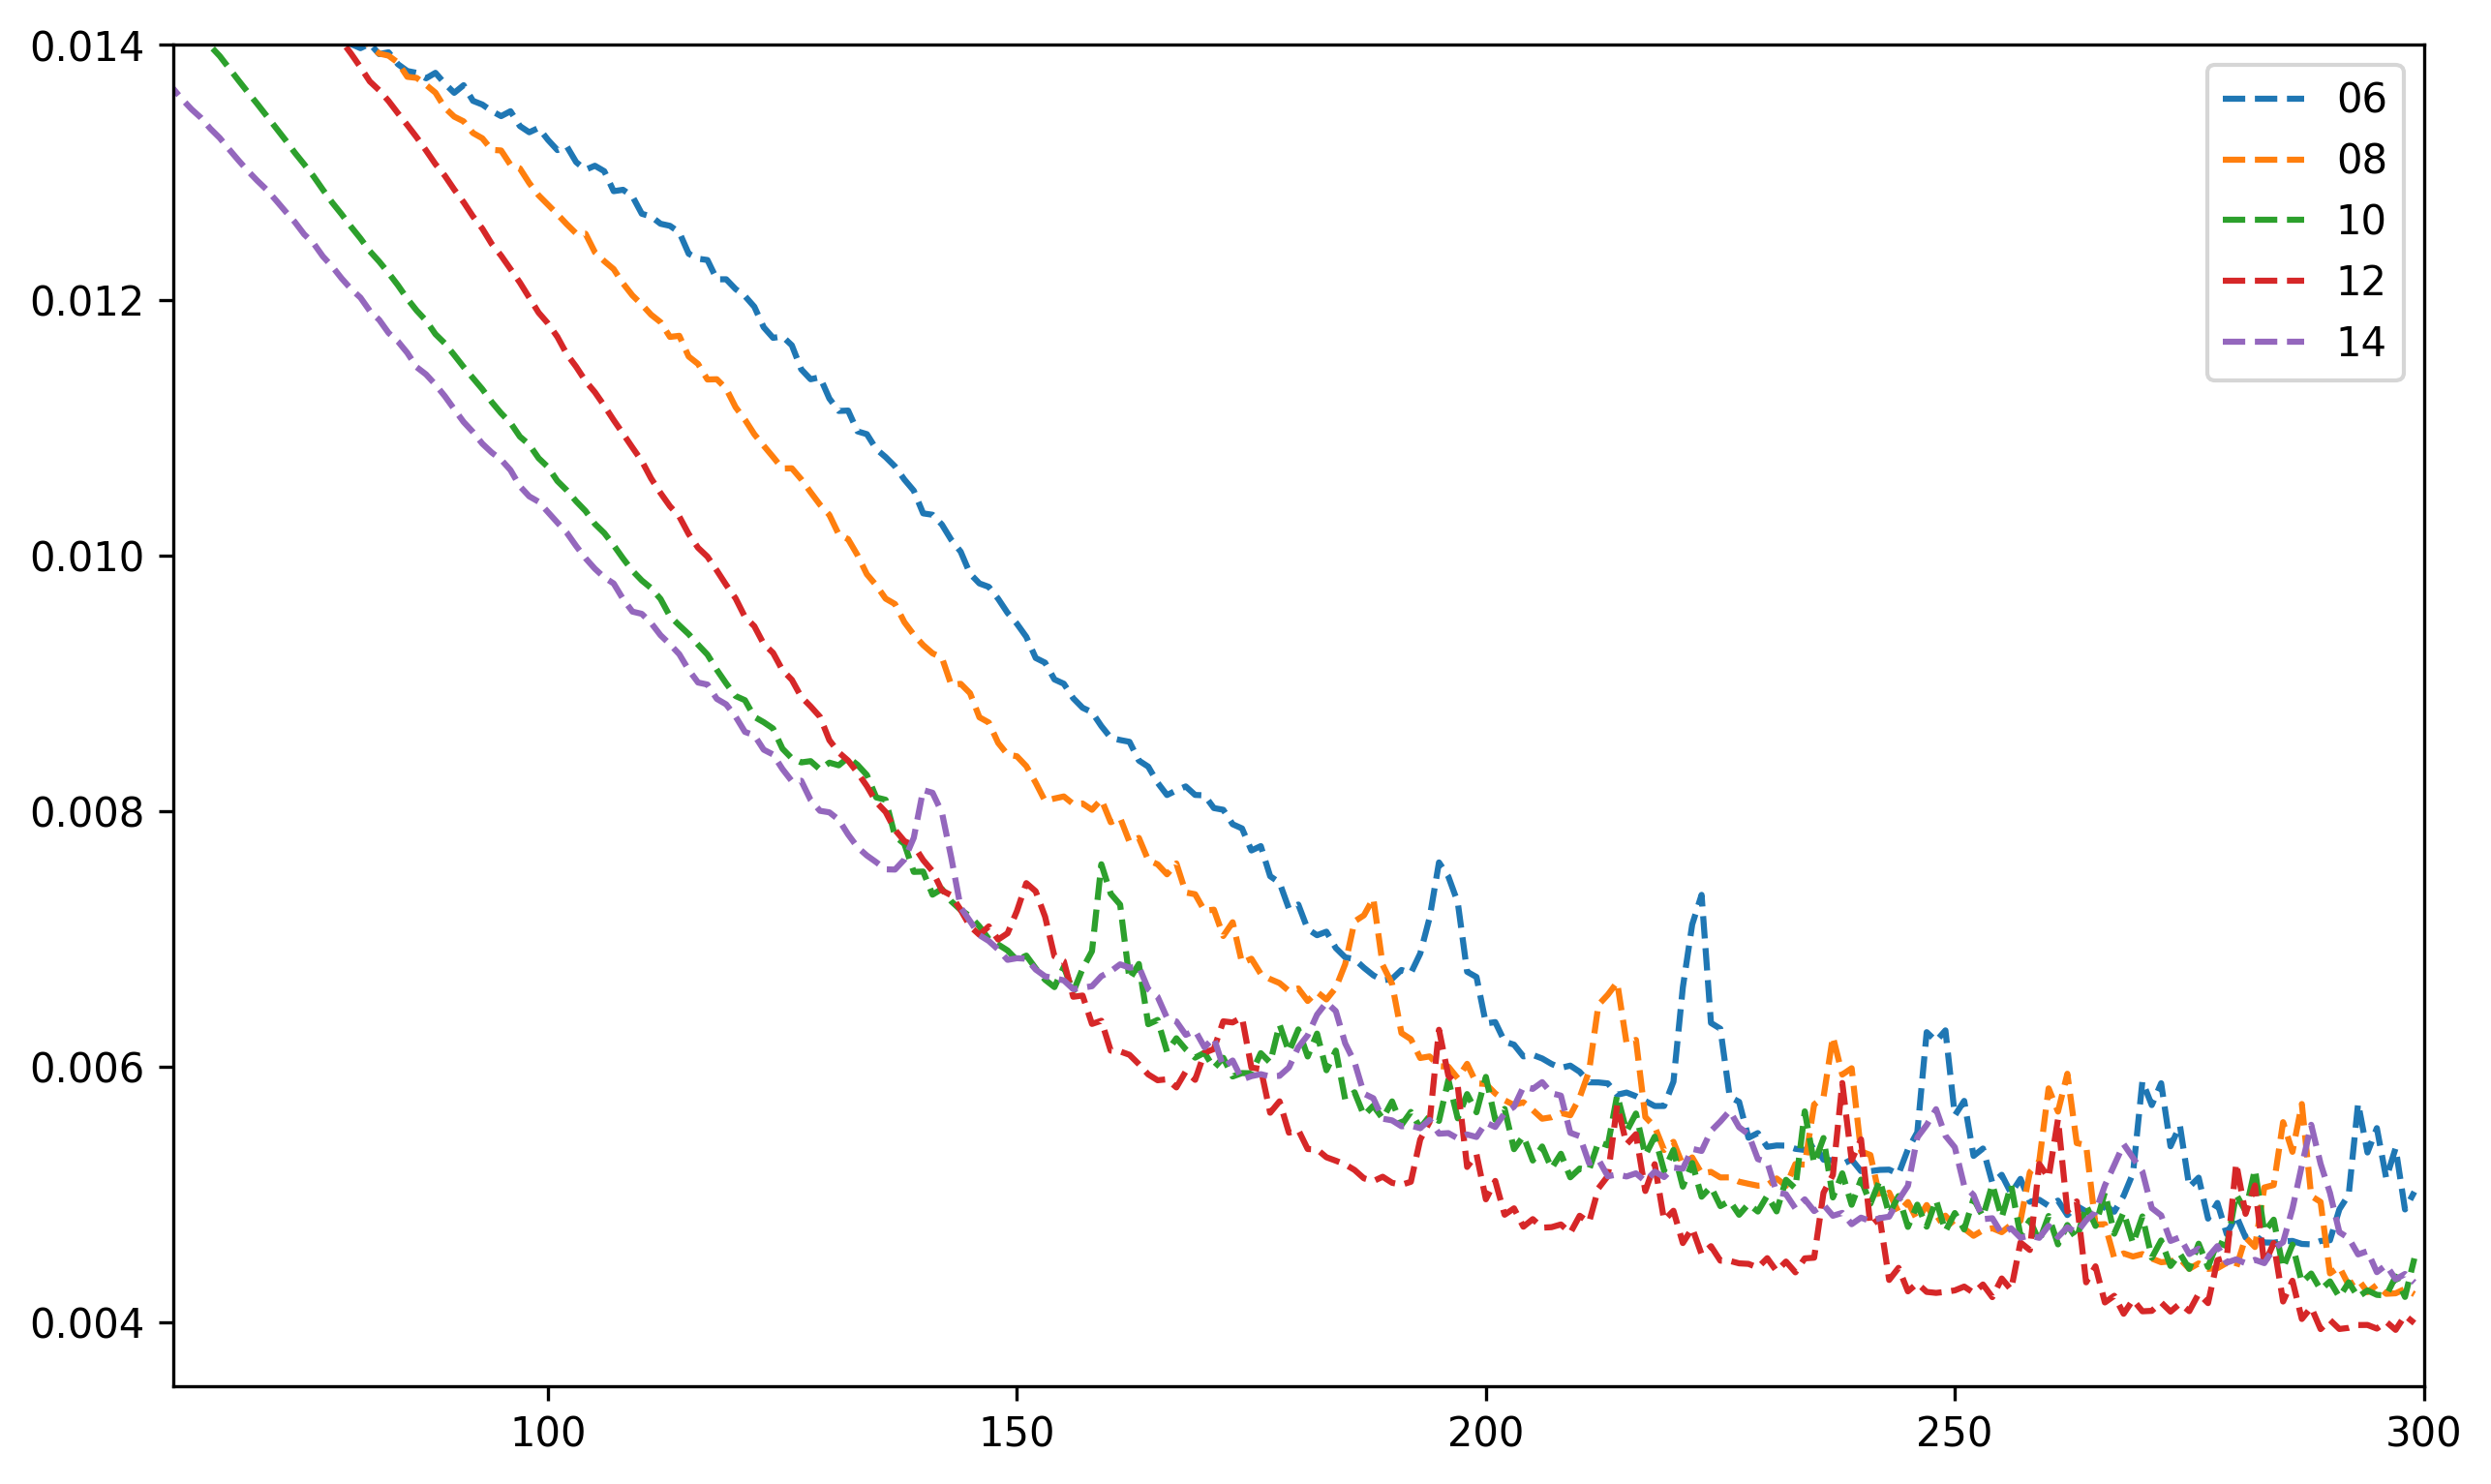

In [181]:
plt.figure(figsize=(10,6),dpi=300)
plt.plot(DJIA_VFOAdam_PF_06_Loss[0:300],'--',label='06')
plt.plot(DJIA_VFOAdam_PF_08_Loss[0:300],'--',label='08')
plt.plot(DJIA_VFOAdam_PF_10_Loss[0:300],'--',label='10')
plt.plot(DJIA_VFOAdam_PF_12_Loss[0:300],'--',label='12')
plt.plot(DJIA_VFOAdam_PF_14_Loss[0:300],'--',label='14')
plt.xlim(30,300)
plt.ylim(0.0035,0.015)
plt.legend()

In [42]:
#saving data about LSTM+MLP
'''
data = pd.DataFrame([DJIA_VFOGD_PF_06_Loss,DJIA_VFOGD_PF_08_Loss,DJIA_VFOGD_PF_10_Loss,DJIA_VFOGD_PF_12_Loss,DJIA_VFOGD_PF_12_5_Loss,DJIA_VFOGD_PF_12_8_Loss],
                    index=['DJIA_VFOGD_PF_06_Loss','DJIA_VFOGD_PF_08_Loss','DJIA_VFOGD_PF_10_Loss','DJIA_VFOGD_PF_12_Loss','DJIA_VFOGD_PF_12_5_Loss','DJIA_VFOGD_PF_12_8_Loss'])
data.to_csv('DJIA_and_ETTh1/DJIA_VFOGD_PF_Loss.csv')

data = pd.DataFrame([DJIA_VFOAdam_PF_06_Loss,DJIA_VFOAdam_PF_08_Loss,DJIA_VFOAdam_PF_10_Loss,DJIA_VFOAdam_PF_12_Loss,DJIA_VFOAdam_PF_14_Loss,DJIA_VFOAdam_PF_16_Loss,DJIA_VFOAdam_PF_18_Loss],
                    index=['DJIA_VFOAdam_PF_06_Loss','DJIA_VFOAdam_PF_08_Loss','DJIA_VFOAdam_PF_10_Loss','DJIA_VFOAdam_PF_12_Loss','DJIA_VFOAdam_PF_14_Loss','DJIA_VFOAdam_PF_16_Loss','DJIA_VFOAdam_PF_18_Loss'])
data.to_csv('DJIA_and_ETTh1/DJIA_VFOAdam_PF_Loss.csv')
'''

In [185]:
#saving data about MLP
'''
data = pd.DataFrame([DJIA_VFOGD_PF_06_Loss,DJIA_VFOGD_PF_08_Loss,DJIA_VFOGD_PF_10_Loss,DJIA_VFOGD_PF_12_Loss],
                    index=['DJIA_VFOGD_PF_06_Loss','DJIA_VFOGD_PF_08_Loss','DJIA_VFOGD_PF_10_Loss','DJIA_VFOGD_PF_12_Loss'])
data.to_csv('DJIA_and_ETTh1/DJIA_VFOGD_PF_Loss_MLP.csv')

'''
data = pd.DataFrame([DJIA_VFOAdam_PF_06_Loss,DJIA_VFOAdam_PF_08_Loss,DJIA_VFOAdam_PF_10_Loss,DJIA_VFOAdam_PF_12_Loss,DJIA_VFOAdam_PF_14_Loss],
                    index=['DJIA_VFOAdam_PF_06_Loss','DJIA_VFOAdam_PF_08_Loss','DJIA_VFOAdam_PF_10_Loss','DJIA_VFOAdam_PF_12_Loss','DJIA_VFOAdam_PF_14_Loss'])
data.to_csv('DJIA_and_ETTh1/DJIA_VFOAdam_PF_Loss_MLP.csv')


In [186]:
#ETTh1 data preprocessing
slide_windows_size = 72  #there are 72 steps a day in total
pre_minutes = 1
df_ETTm2 = pd.read_csv(r'./data/ETTh1.csv')
del df_ETTm2['date']
df_ETTm2['label'] = df_ETTm2['OT'].shift(-pre_minutes)
df_ETTm2.dropna()
scaler = StandardScaler()
sca_X_ETTm2 = scaler.fit_transform(df_ETTm2.iloc[:,:-1])
deq_ETTm2 = deque(maxlen=slide_windows_size)
X_ETTm2 = []
for i in sca_X_ETTm2:
    deq_ETTm2.append(list(i))
    if len(deq_ETTm2)==slide_windows_size:
        X_ETTm2.append(list(deq_ETTm2))
X_ETTm2 = X_ETTm2[:-pre_minutes]
y_ETTm2 = scaler.fit_transform(pd.DataFrame(df_ETTm2['label'].values[slide_windows_size-1:-pre_minutes]))
X_ETTm2, y_ETTm2 = torch.Tensor(X_ETTm2),torch.Tensor(y_ETTm2)
#X_DJIA, y_DJIA = X_DJIA.to(device), y_DJIA.to(device)
X_train,X_test,y_train,y_test = train_test_split(X_ETTm2,y_ETTm2,test_size=0.2,shuffle=False)

In [187]:
#ETTh1 network model 
class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.rnn = nn.LSTM(
            input_size=7,
            hidden_size=64,
            num_layers=3,
            dropout=0.2,
            batch_first=True
        )
        self.linear_1 = nn.Linear(64,32)
        self.linear_2 = nn.Linear(32,1)
    
    def forward(self,x):
        out,(hn,cn) = self.rnn(x)
        hn = self.linear_1(hn[2])
        hn = self.linear_2(hn)
        hn = hn.view(-1,1)
        return out,hn

In [192]:
#ETTh1 network model based on MLP
class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.linear_0 = nn.Linear(504,128)
        self.linear_1 = nn.Linear(128,64)
        self.linear_2 = nn.Linear(64,32)
        self.linear_3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = x.view(-1,504)
        hn0 = self.linear_0(x)
        hn1 = self.linear_1(hn0)
        hn2 = self.linear_2(hn1)
        hn3 = self.linear_3(hn2)
        hn3 = hn3.view(-1,1)
        return out,hn3

In [342]:
#ETTh1 train and test
epoch = 300
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

######
r = 0.4
#ETTh1_VFOGD_PF_06_Loss = []
ETTh1_VFOAdam_PF_04_Loss = []
######

Best_Accuracy_MSE = 10
Best_Accuracy_MAE = 10
Best_Accuracy_MAPE = 10
Best_Accuracy_RSE = 10
Best_Accuracy_R2 = -10

#choose optimizers
#optimizer1 = torch.optim.SGD(model.rnn.parameters(),lr=0.01,momentum=0.5)
#optimizer2 = VFOSGD_PF([{'params': model.linear_1.parameters()},
#                       {'params': model.linear_2.parameters()}],r=r,lr=0.01)
#optimizer2 = VFOAdam_PF([{'params': model.linear_1.parameters()},
#                       {'params': model.linear_2.parameters()}],r=r,lr=0.01)
#optimizer = VFOSGD_PF(model.parameters(),r=r,lr=0.001)
optimizer = VFOAdam_PF(model.parameters(),r=r,lr=0.0001)
for i in range(epoch):
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        model.zero_grad()
        out,hn4 = model(X_batch)
        loss = criterion(hn4,y_batch)       
        loss.backward()
        #optimizer1.step()
        #optimizer2.step()
        optimizer.step()
        loss_sum += loss
    print('epoch:{0}'.format(i+1)+'\n'+'loss:{0}'.format(loss_sum.cpu().detach().numpy()))
    
    ######
    ETTh1_VFOAdam_PF_04_Loss.append(loss_sum.cpu().detach().numpy())
    ######
    
    model.eval()
    X_test, y_test = X_test.to(device), y_test.to(device)
    out_1,hn_1 = model(X_test)
    
    MSE_a = MSE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    MAE_a = MAE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    MAPE_a = MAPE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    RSE_a = RSE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    R2_a = R2(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy())
    print('MSE',MSE_a)
    print('MAE',MAE_a)
    print('MAPE',MAPE_a)
    print('RSE',RSE_a)
    print('R2',R2_a)
    print('\n')
    if MSE_a < Best_Accuracy_MSE:
        Best_Accuracy_MSE = MSE_a
        Best_Accuracy_MAE = MAE_a
        Best_Accuracy_MAPE = MAPE_a
        Best_Accuracy_RSE = RSE_a
        Best_Accuracy_R2 = R2_a
    model.train()
######   
ETTh1_VFOAdam_PF_04_Loss.append(Best_Accuracy_MSE)
ETTh1_VFOAdam_PF_04_Loss.append(Best_Accuracy_MAE)
ETTh1_VFOAdam_PF_04_Loss.append(Best_Accuracy_MAPE)
ETTh1_VFOAdam_PF_04_Loss.append(Best_Accuracy_RSE)
ETTh1_VFOAdam_PF_04_Loss.append(Best_Accuracy_R2)
######

epoch:1
loss:48.07728958129883
MSE 0.28536937
MAE 0.45092145
MAPE 10.286068
RSE 2.6518204
R2 -0.7611017238387132


epoch:2
loss:20.76303482055664
MSE 0.09207661
MAE 0.23387307
MAPE 0.91374296
RSE 1.2064524
R2 0.43176704323602577


epoch:3
loss:7.757318019866943
MSE 0.060153138
MAE 0.19751827
MAPE 0.8983349
RSE 0.6953114
R2 0.6287765587977563


epoch:4
loss:4.996466159820557
MSE 0.049607277
MAE 0.17229335
MAPE 0.88523644
RSE 0.60643595
R2 0.6938582886517086


epoch:5
loss:4.7014265060424805
MSE 0.047258295
MAE 0.16709407
MAPE 1.0999264
RSE 0.5875945
R2 0.7083545911428102


epoch:6
loss:4.471424102783203
MSE 0.04527353
MAE 0.16285905
MAPE 0.6887029
RSE 0.5715999
R2 0.7206031496889178


epoch:7
loss:4.238333702087402
MSE 0.043267544
MAE 0.15809482
MAPE 0.6352515
RSE 0.5557194
R2 0.7329827165502663


epoch:8
loss:4.036281585693359
MSE 0.041325875
MAE 0.1538611
MAPE 0.74140596
RSE 0.538949
R2 0.744965372507713


epoch:9
loss:3.8261919021606445
MSE 0.039281867
MAE 0.14937188
MAPE 0.7776007
R

epoch:72
loss:1.3321523666381836
MSE 0.013097373
MAE 0.0849772
MAPE 0.7382357
RSE 0.2991097
R2 0.9191721058427874


epoch:73
loss:1.405451774597168
MSE 0.014513274
MAE 0.09119588
MAPE 0.38709888
RSE 0.29006776
R2 0.9104341362575571


epoch:74
loss:1.3166494369506836
MSE 0.013008229
MAE 0.084753275
MAPE 0.29497695
RSE 0.2984664
R2 0.9197222247814254


epoch:75
loss:1.3766839504241943
MSE 0.014105965
MAE 0.08969012
MAPE 0.91956073
RSE 0.28717402
R2 0.9129477671274165


epoch:76
loss:1.2835912704467773
MSE 0.012814122
MAE 0.08417627
MAPE 0.47369456
RSE 0.29656374
R2 0.9209201215859365


epoch:77
loss:1.339424967765808
MSE 0.013682264
MAE 0.08813763
MAPE 0.43364057
RSE 0.283413
R2 0.9155625593143901


epoch:78
loss:1.2442963123321533
MSE 0.012486118
MAE 0.082944445
MAPE 0.68754876
RSE 0.2918499
R2 0.9229443436426168


epoch:79
loss:1.3106213808059692
MSE 0.013286766
MAE 0.0865715
MAPE 0.36581835
RSE 0.2790924
R2 0.9180032999982028


epoch:80
loss:1.2163747549057007
MSE 0.011889798
MAE 0.08

epoch:141
loss:0.8838714957237244
MSE 0.008267315
MAE 0.066312194
MAPE 0.29292944
RSE 0.2284549
R2 0.9489798655467663


epoch:142
loss:0.8236595988273621
MSE 0.007994439
MAE 0.06489895
MAPE 0.68675536
RSE 0.22214262
R2 0.9506638706312819


epoch:143
loss:0.8006794452667236
MSE 0.008261864
MAE 0.065898165
MAPE 0.3447944
RSE 0.22175846
R2 0.9490135063128803


epoch:144
loss:0.8145062327384949
MSE 0.008390383
MAE 0.06596173
MAPE 11.283179
RSE 0.22239786
R2 0.9482203775873752


epoch:145
loss:0.8243810534477234
MSE 0.00788989
MAE 0.06332547
MAPE 0.34424168
RSE 0.22149627
R2 0.9513090680551061


epoch:146
loss:0.827908992767334
MSE 0.009562522
MAE 0.073910035
MAPE 0.26306015
RSE 0.25107044
R2 0.9409867398440077


epoch:147
loss:0.8523945808410645
MSE 0.008747395
MAE 0.07013832
MAPE 0.5529742
RSE 0.23428486
R2 0.946017141561147


epoch:148
loss:0.9002471566200256
MSE 0.015943212
MAE 0.10069153
MAPE 0.46878958
RSE 0.28811374
R2 0.9016095561366119


epoch:149
loss:1.2202457189559937
MSE 0.0200

epoch:210
loss:0.8940243124961853
MSE 0.011541731
MAE 0.08176013
MAPE 0.34543017
RSE 0.2721518
R2 0.92877244983313


epoch:211
loss:1.0680840015411377
MSE 0.009503552
MAE 0.07404645
MAPE 0.35495272
RSE 0.24936594
R2 0.9413506642308641


epoch:212
loss:0.8361852765083313
MSE 0.008489512
MAE 0.0693071
MAPE 0.22760393
RSE 0.23276477
R2 0.9476086183935548


epoch:213
loss:0.8401734232902527
MSE 0.007731676
MAE 0.063331634
MAPE 0.36292675
RSE 0.21706636
R2 0.9522854558239799


epoch:214
loss:0.8087378144264221
MSE 0.008652359
MAE 0.06731596
MAPE 0.43691537
RSE 0.2304118
R2 0.9466036376075587


epoch:215
loss:0.939200222492218
MSE 0.010540111
MAE 0.07835911
MAPE 2.5496829
RSE 0.2603386
R2 0.9349537465974423


epoch:216
loss:0.9795023202896118
MSE 0.008320959
MAE 0.067895666
MAPE 0.38182193
RSE 0.23017083
R2 0.9486488115477724


epoch:217
loss:0.7883790731430054
MSE 0.0076538725
MAE 0.064349174
MAPE 0.25187293
RSE 0.22013825
R2 0.9527656077946687


epoch:218
loss:0.7863737940788269
MSE 0.0076

epoch:279
loss:0.7721512913703918
MSE 0.007958228
MAE 0.064152785
MAPE 0.38782173
RSE 0.22271138
R2 0.950887336534735


epoch:280
loss:0.8549805879592896
MSE 0.009404785
MAE 0.07403266
MAPE 0.22905968
RSE 0.24726595
R2 0.941960185472677


epoch:281
loss:0.84602290391922
MSE 0.007851995
MAE 0.06620447
MAPE 0.2575328
RSE 0.22307132
R2 0.9515429344303092


epoch:282
loss:0.7746606469154358
MSE 0.007436371
MAE 0.06274206
MAPE 0.30006346
RSE 0.21331634
R2 0.9541078753230484


epoch:283
loss:0.7853881120681763
MSE 0.008142333
MAE 0.06528668
MAPE 0.5536561
RSE 0.22196478
R2 0.949751168300331


epoch:284
loss:0.8009417057037354
MSE 0.009214339
MAE 0.07140673
MAPE 0.2928468
RSE 0.24265347
R2 0.9431354954478669


epoch:285
loss:0.9238955974578857
MSE 0.008232645
MAE 0.067985445
MAPE 0.23817472
RSE 0.23067889
R2 0.9491938276771531


epoch:286
loss:0.7630503177642822
MSE 0.0074671065
MAE 0.06396729
MAPE 0.2879493
RSE 0.21777733
R2 0.9539181962667709


epoch:287
loss:0.7850750088691711
MSE 0.007527

In [347]:
print(ETTh1_VFOAdam_PF_04_Loss[300:])
print(ETTh1_VFOAdam_PF_06_Loss[300:])
print(ETTh1_VFOAdam_PF_08_Loss[300:])
print(ETTh1_VFOAdam_PF_10_Loss[300:])
print(ETTh1_VFOAdam_PF_12_Loss[300:])

[0.007169298, 0.061388474, 0.22801879, 0.21073638, 0.9557560658444515]
[0.0074908794, 0.06355289, 0.22687373, 0.2168832, 0.9537714900720298]
[0.0075203152, 0.06312692, 0.2507534, 0.2153487, 0.9535898352809195]
[0.0073434273, 0.06067144, 0.3209829, 0.21599978, 0.9546814629494226]
[0.007747205, 0.06257502, 0.27945656, 0.22260867, 0.9521896264686617]


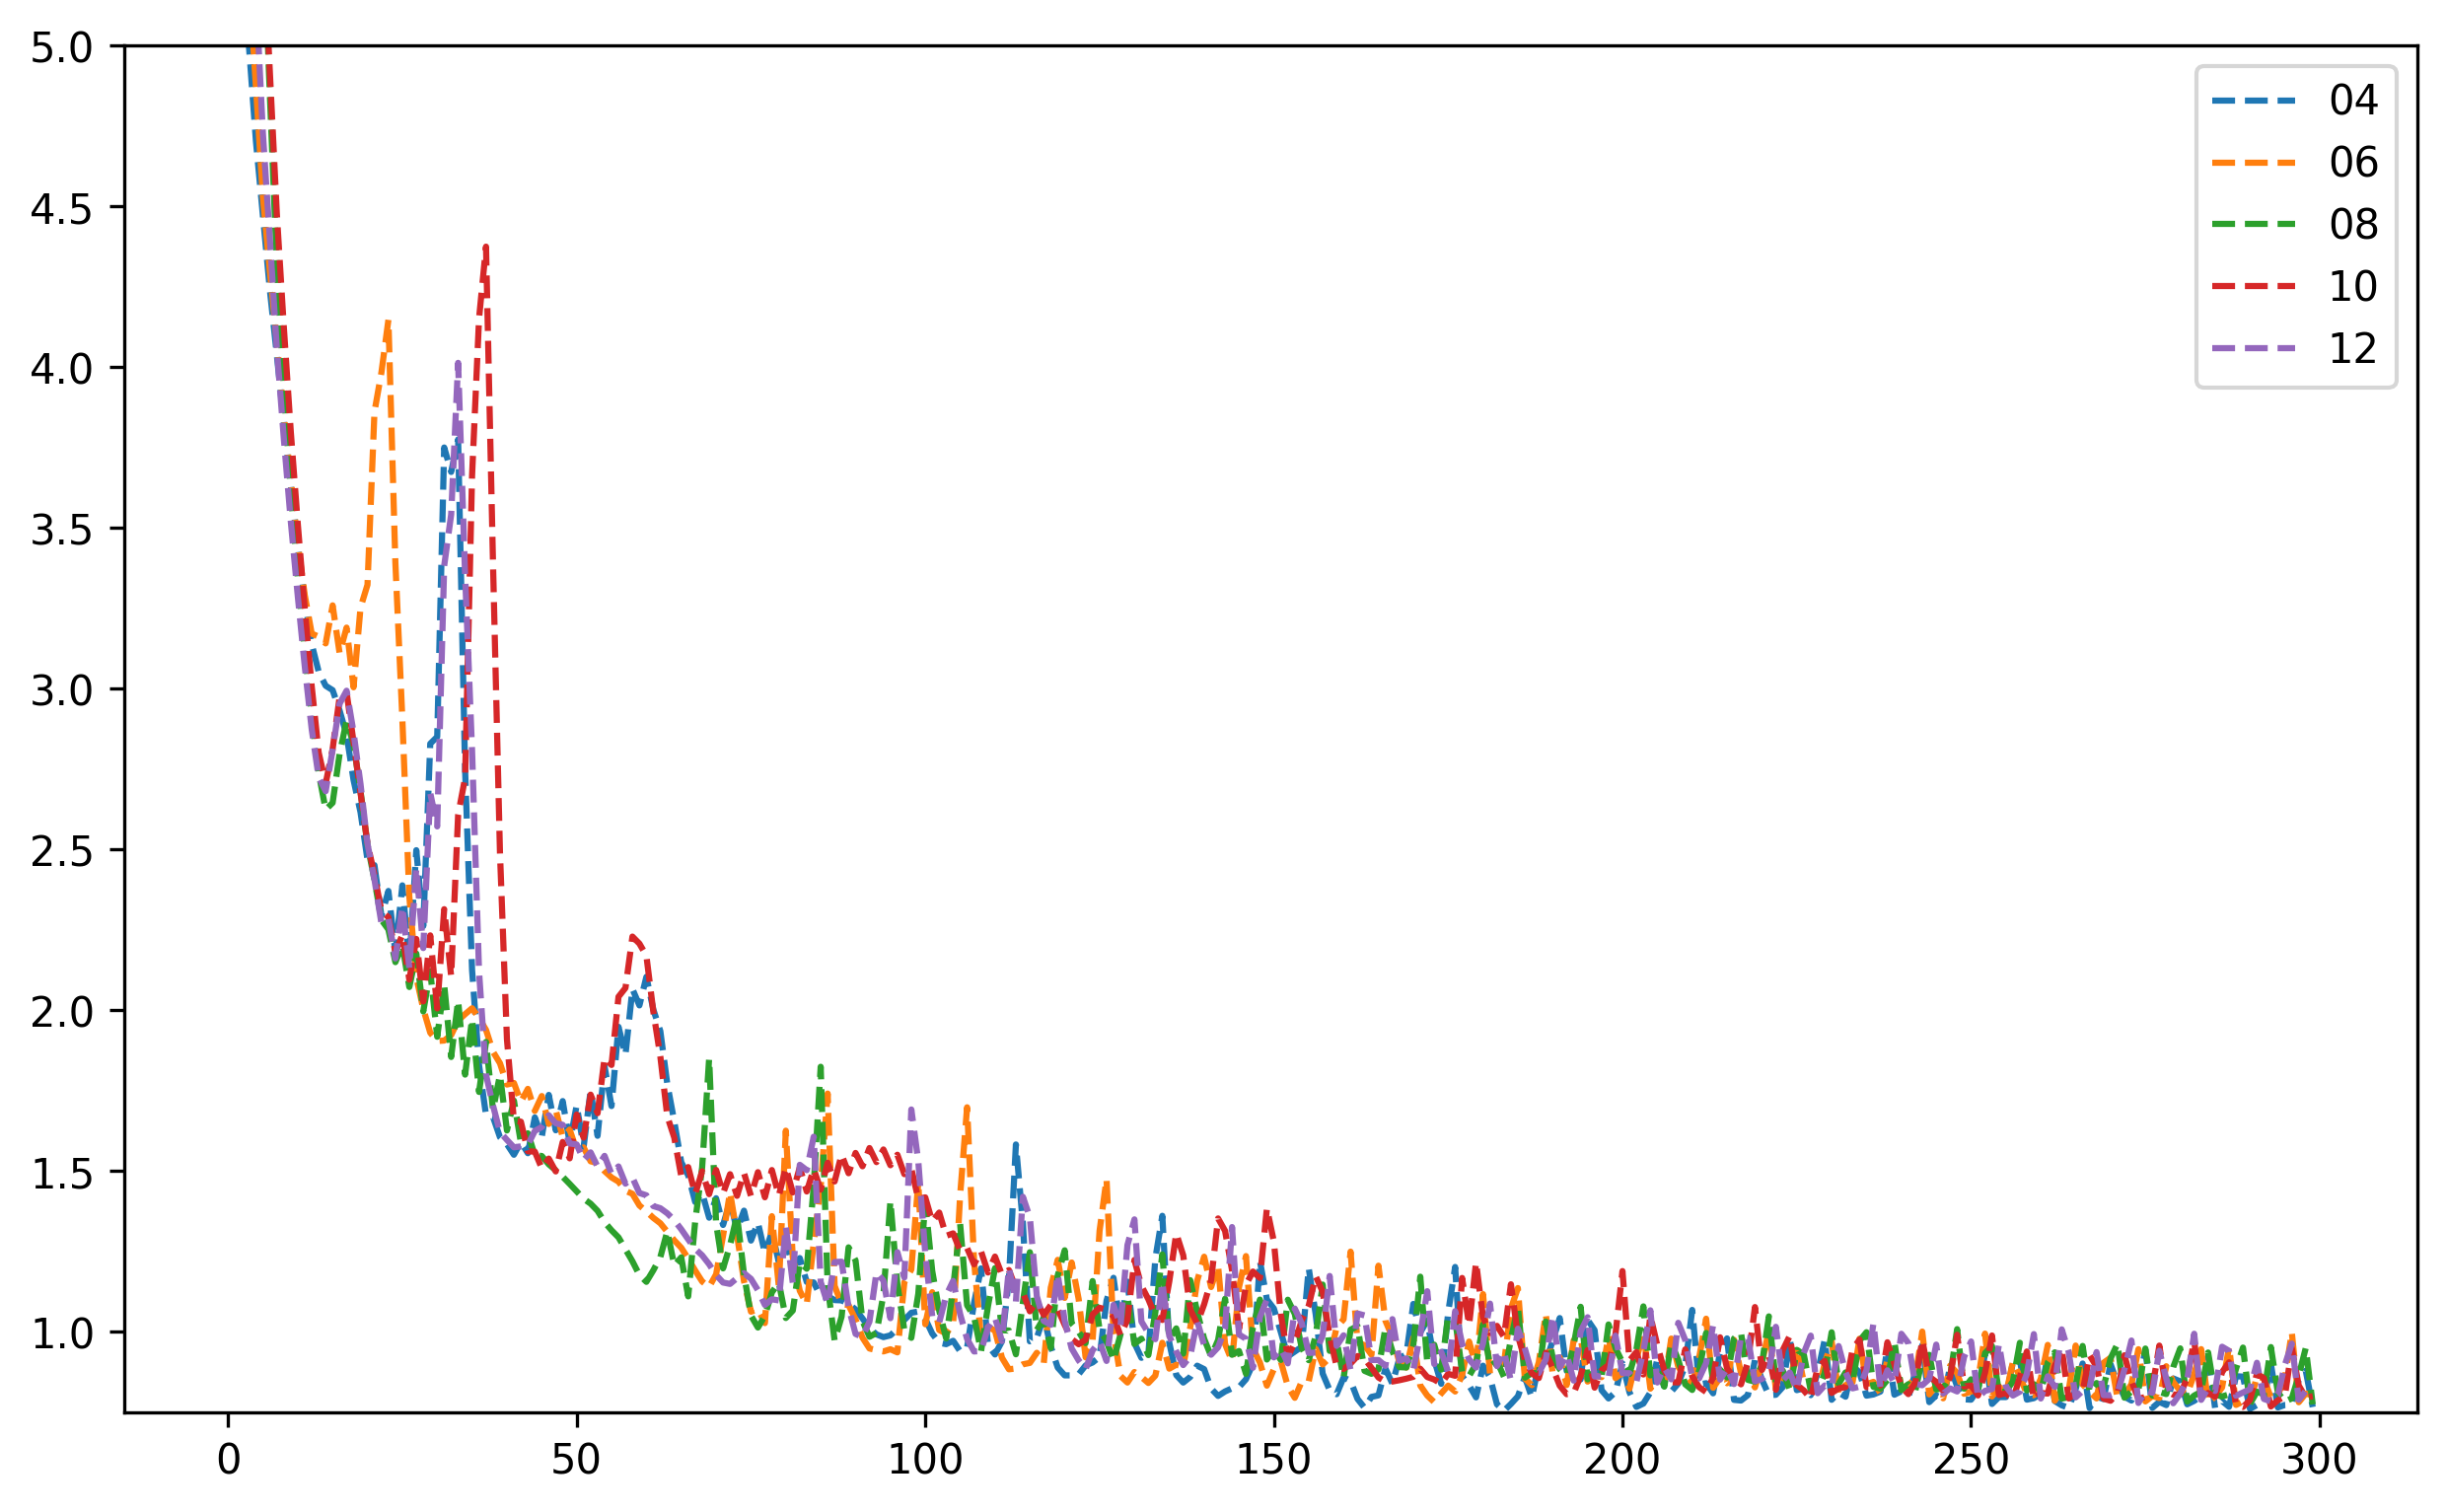

In [354]:
plt.figure(figsize=(10,6),dpi=300)
plt.plot(ETTh1_VFOAdam_PF_04_Loss[0:300],'--',label='04')
plt.plot(ETTh1_VFOAdam_PF_06_Loss[0:300],'--',label='06')
plt.plot(ETTh1_VFOAdam_PF_08_Loss[0:300],'--',label='08')
plt.plot(ETTh1_VFOAdam_PF_10_Loss[0:300],'--',label='10')
plt.plot(ETTh1_VFOAdam_PF_12_Loss[0:300],'--',label='12')
plt.ylim(0.75,5)
plt.legend()

In [16]:
#saving data about LSTM+MLP
'''
data = pd.DataFrame([ETTh1_VFOGD_PF_06_Loss,ETTh1_VFOGD_PF_08_Loss,ETTh1_VFOGD_PF_10_Loss,ETTh1_VFOGD_PF_12_Loss],
                    index=['ETTh1_VFOGD_PF_06_Loss','ETTh1_VFOGD_PF_08_Loss','ETTh1_VFOGD_PF_10_Loss','ETTh1_VFOGD_PF_12_Loss'])
data.to_csv('DJIA_and_ETTh1/ETTh1_VFOGD_PF_Loss.csv')

data = pd.DataFrame([ETTh1_VFOAdam_PF_06_Loss,ETTh1_VFOAdam_PF_08_Loss,ETTh1_VFOAdam_PF_10_Loss,ETTh1_VFOAdam_PF_12_Loss,ETTh1_VFOAdam_PF_14_Loss,ETTh1_VFOAdam_PF_16_Loss,ETTh1_VFOAdam_PF_18_Loss],
                    index=['ETTh1_VFOAdam_PF_06_Loss','ETTh1_VFOAdam_PF_08_Loss','ETTh1_VFOAdam_PF_10_Loss','ETTh1_VFOAdam_PF_12_Loss','ETTh1_VFOAdam_PF_14_Loss','ETTh1_VFOAdam_PF_16_Loss','ETTh1_VFOAdam_PF_18_Loss'])
data.to_csv('DJIA_and_ETTh1/ETTh1_VFOAdam_PF_Loss.csv')
'''

In [355]:
#saving data about MLP
'''
data = pd.DataFrame([ETTh1_VFOGD_PF_06_Loss,ETTh1_VFOGD_PF_08_Loss,ETTh1_VFOGD_PF_10_Loss,ETTh1_VFOGD_PF_12_Loss],
                    index=['ETTh1_VFOGD_PF_06_Loss','ETTh1_VFOGD_PF_08_Loss','ETTh1_VFOGD_PF_10_Loss','ETTh1_VFOGD_PF_12_Loss'])
data.to_csv('DJIA_and_ETTh1/ETTh1_VFOGD_PF_Loss_MLP.csv')
'''
data = pd.DataFrame([ETTh1_VFOAdam_PF_04_Loss,ETTh1_VFOAdam_PF_06_Loss,ETTh1_VFOAdam_PF_08_Loss,ETTh1_VFOAdam_PF_10_Loss,ETTh1_VFOAdam_PF_12_Loss],
                    index=['ETTh1_VFOAdam_PF_04_Loss','ETTh1_VFOAdam_PF_06_Loss','ETTh1_VFOAdam_PF_08_Loss','ETTh1_VFOAdam_PF_10_Loss','ETTh1_VFOAdam_PF_12_Loss'])
data.to_csv('DJIA_and_ETTh1/ETTh1_VFOAdam_PF_Loss_MLP.csv')
